In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from roof_segmentation import *


In [171]:
import json 
import numpy as np
import scipy.optimize
from tqdm import tqdm

In [4]:
with open("../../data/Majorna2021/CityModel.json") as src:
    cm = json.load(src)
    buildings = cm['Buildings']

In [5]:
def get_roof_data(building):
    #footprint = [ [f['x'], f['y']] for f in building['Footprint']]
    #footprint = Polygon(footprint)
    points = [[p['x'], p['y'],p['z']] for p in building['RoofPoints']]
    points = np.array(points)
    return points

In [6]:
pc = get_roof_data(buildings[120])

In [132]:
def segment_roof(
    point_cloud, max_radius=0.2, normals_angle_threshold=2, min_points=20
):
    regions = region_growing_segmentation_3d(
        point_cloud=point_cloud,
        max_radius=max_radius,
        normals_angle_threshold=normals_angle_threshold,
    )
    xy_normal_vector = [0, 0, 1]
    filtered_regions = [r[2] for r in regions if len(r[2]) > min_points]
    return filtered_regions

def segment_score(roof_segments,point_cloud):
    segmented_points = 0
    for segment in roof_segments:
        segmented_points += len(segment)
    segment_ratio = segmented_points / len(point_cloud)
    return len(roof_segments) ** 2 * segment_ratio

def optimize_roof_segmentation(point_cloud, max_radius=2, min_points=16, max_iter=200):
    

    def segment_value(angle_threshold):
        roof_segments = segment_roof(
            point_cloud, max_radius, angle_threshold, min_points
        )
        return -segment_score(roof_segments, point_cloud)

    opt_result = scipy.optimize.minimize_scalar(
        segment_value,
        bounds=(0.5, 10.0),
        # bracket=(0, 5, 10),
        method="brent",
        tol=1e-2,
        options={"maxiter": max_iter},
    )
    return opt_result

In [133]:
optimize_roof_segmentation(pc)

     fun: -3.9689521345407504
    nfev: 19
     nit: 8
 success: True
       x: 17.127406729592035

In [155]:
steps = np.arange(0.5,10,0.25)

In [144]:
pc = get_roof_data(buildings[151])
print(len(pc))

33


3.75:0.6060606060606061
3.75


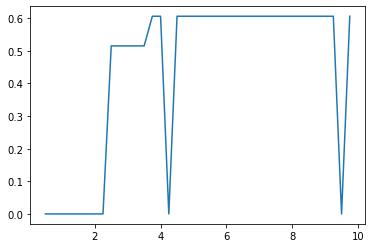

In [161]:
xs = []
for s in steps:
    roof_segments  = segment_roof(pc,2,normals_angle_threshold=s,min_points=16)
    xs.append(segment_score(roof_segments, pc))
xs = np.array(xs)
midx = np.argmax(xs)
print(f"{steps[midx]}:{xs[midx]}")

plot(steps,xs)
np.argsort(xs)
segmax = np.max(xs)
minmax = segmax *0.9
possible_angles = xs>minmax
print(np.min(steps[possible_angles]))

In [146]:
r = optimize_roof_segmentation(pc, max_iter=200)
print(f"X: {r.x} fun: {-r.fun}")
roof_segments = segment_roof(pc,2,r.x,min_points = 16)
print(segment_score(roof_segments,pc))

X: 9.328428763646503 fun: 0.6060606060606061
0.6060606060606061


In [172]:
steps = arange(0.5,10,0.2)
min_good_angle = []
for b in tqdm(buildings):
    xs = []
    pc = get_roof_data(b)
    if len(pc)<32:
        continue
    for s in steps:
        roof_segments  = segment_roof(pc,2,normals_angle_threshold=s,min_points=16)
        xs.append(segment_score(roof_segments, pc))
    np.argsort(xs)
    segmax = np.max(xs)
    minmax = segmax *0.9
    possible_angles = xs>minmax
    try:
        min_good_angle.append(np.min(steps[possible_angles]))
    except ValueError:
        pass

100%|██████████| 3096/3096 [3:35:40<00:00,  4.18s/it]    


(array([191.,  85.,  98.,  68.,  52.,  92.,  72.,  72.,  92.,  86.,  88.,
        135.,  92.,  85., 132.,  91.,  65.,  86.,  53.,  65.]),
 array([0.5 , 0.97, 1.44, 1.91, 2.38, 2.85, 3.32, 3.79, 4.26, 4.73, 5.2 ,
        5.67, 6.14, 6.61, 7.08, 7.55, 8.02, 8.49, 8.96, 9.43, 9.9 ]),
 <BarContainer object of 20 artists>)

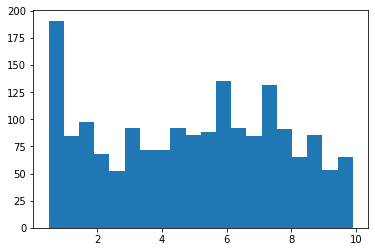

In [192]:
hist(min_good_angle, bins=20)

In [176]:
min_good_angle2 = copy(min_good_angle)

In [178]:
min_good_angle_sort = np.sort(min_good_angle2)

In [188]:
H,X1 = np.histogram( min_good_angle, bins = 20, density=True)
dx = X1[1] - X1[0]
F1 = np.cumsum(H)*dx

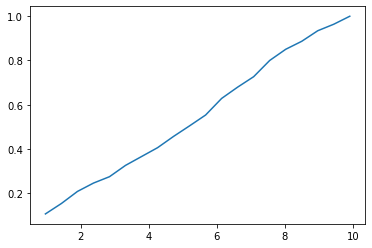

In [189]:
plot(X1[1:],F1)

In [190]:
H

array([0.22576832, 0.10047281, 0.11583924, 0.08037825, 0.06146572,
       0.10874704, 0.08510638, 0.08510638, 0.10874704, 0.10165485,
       0.10401891, 0.15957447, 0.10874704, 0.10047281, 0.15602837,
       0.10756501, 0.07683215, 0.10165485, 0.06264775, 0.07683215])

In [191]:
X1

array([0.5 , 0.97, 1.44, 1.91, 2.38, 2.85, 3.32, 3.79, 4.26, 4.73, 5.2 ,
       5.67, 6.14, 6.61, 7.08, 7.55, 8.02, 8.49, 8.96, 9.43, 9.9 ])